<a href="https://colab.research.google.com/github/bennyqp/artificial-inspiration/blob/main/ai_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image classification 

This notebook was created for the project ["Artificial Inspiration"](https://github.com/bennyqp/artificial-inspiration). 

It contains different techniques of image classification which have been collected from different sources in order to classify an image according to certain parameters as comprehensively as possible. 

All the results of the classification are then saved in a csv file, which is used in the rest of the project. The classified images are distributed in three-dimensional space based on the results in a Unity application and can then be filtered and clustered. 

All sources of the different techniques are mentioned in the course of the notebook. 

#Image Embedding by Jared Winick

The image embedding used here is by [Jared Winick](https://github.com/jaredwinick). It uses a fork of his [img2vec-keras module](https://github.com/jaredwinick/img2vec-keras) which is used to assign vectors to the images. The corresponding part of this notebook was taken from an [example notebook by Jared Winick](https://colab.research.google.com/drive/14OvmH6KvoQJ41jb6QRL3FgwI61vq-UAJ). 

https://github.com/jaredwinick/img2vec-keras

In [ ]:
!pip install git+git://github.com/bennyqp/img2vec-keras.git

In [2]:
from img2vec_keras import Img2Vec

from IPython.display import Image, display, Javascript

import glob

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import cv2

import imutils
from base64 import b64decode


img2vec = Img2Vec()

102973440/102967424 [==============================] - 1s 0us/step


In [3]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
          if not entry.startswith("."):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

#Import Images from Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####Set the input folder and the name for the output folder

The input path is where the images are currently located. 

The output name is the name of the folder where the final images should be located.

The baseFolder is the folder where the output folder will be located. 

In [14]:
inputPath = "/content/drive/MyDrive/input"
outputName = "finalImages"
baseFolder = "/content/drive/MyDrive/imageClassification"

# 1. Get the Google Drive image ID and scale the images to a smaller size

For the project we need the Google Drive ID to be able to access specific images later.

Also, we don't need the images in their original resolution. For the Unity application a smaller resolution is sufficient. In addition, the image classification is drastically accelerated. 

So the ID of the original images is saved, then the images are scaled and saved in a smaller format in a new folder.

In [15]:
#Set the reduced image size
newImgWidth = 256
newImgHeight = 256

In [16]:
import os
from IPython.display import clear_output
from PIL import Image
!apt-get install -qq xattr


outputPath = os.path.join(baseFolder, outputName)
if os.path.exists(outputPath) == False:
  os.mkdir(outputPath)
if os.path.exists(outputName) == False:
  os.mkdir(outputName)

image_paths = []
dataDirs = getListOfFiles(inputPath)
print("")
print("Adding " + str(len(dataDirs)) + " Images")


#Make a small version of each image and create an array with the ID of the original files
originalImageIDs = []

counter = 0
for fileName in dataDirs:
  
  #Determine path of the original image and name of the original image
  currentFilePath = fileName
  fname = os.path.basename(fileName)

  #Get Id of the original image and add it to the array
  currentFileId = !xattr -p 'user.drive.id' $currentFilePath
  originalImageIDs.append(currentFileId[0])

  smallImgPath = os.path.join(outputPath, fname)
  smallImgColabPath = os.path.join(outputName, fname)

  #Resize 
  im = Image.open(currentFilePath)
  im_resized = im.resize((newImgWidth, newImgHeight), Image.ANTIALIAS)
  im_resized.save(smallImgPath, quality=95)
  im_resized.save(smallImgColabPath, quality=95)

  #Add Colab Path
  image_paths.append(smallImgColabPath)

  #Loop Information
  if (counter % 10 == 0):
    print(str(counter) + " / " + str(len(dataDirs)))
  counter = counter + 1

print("done.")


Adding 68 Images
0 / 68
10 / 68
20 / 68
30 / 68
40 / 68
50 / 68
60 / 68
done.


#2. Compute image vectors 

###2.1 image embedding

Now we will perform the image embedding. As mentioned before the image embedding used here is by [Jared Winick](https://github.com/jaredwinick):

https://github.com/jaredwinick/img2vec-keras

In [17]:
image_vectors = {}
counter = 0
for image_path in image_paths:
  vector = img2vec.get_vec(image_path)
  image_vectors[image_path] = vector

  counter = counter + 1;
  if (counter % 10 == 0):
    print("Analyzed " + str(counter) + " of " + str(len(image_paths)) + " Images.")
print("done.")

Analyzed 10 of 68 Images.
Analyzed 20 of 68 Images.
Analyzed 30 of 68 Images.
Analyzed 40 of 68 Images.
Analyzed 50 of 68 Images.
Analyzed 60 of 68 Images.
done.


###2.2 Dimension reduction

Since we only need three-dimensional vectors for the project in order to distribute the images in three-dimensional space, we perform a dimensional reduction. For this we use the T-SNE and the PCA algorithm.

In [18]:
X = np.stack(list(image_vectors.values()))

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(X)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))
print(np.shape(pca_result_50))

    
tsne = TSNE(n_components=3, verbose=1, n_iter=3000)
tsne_result = tsne.fit_transform(pca_result_50)

tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

Cumulative explained variation for 50 principal components: 0.9419956207275391
(68, 50)
[t-SNE] Computing 67 nearest neighbors...
[t-SNE] Indexed 68 samples in 0.001s...
[t-SNE] Computed neighbors for 68 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 68 / 68
[t-SNE] Mean sigma: 14.497902
[t-SNE] KL divergence after 250 iterations with early exaggeration: 125.099579
[t-SNE] KL divergence after 3000 iterations: 1.006268


We can check the shape of the result to see if we did everything right:

In [19]:
np.shape(tsne_result_scaled)

(68, 3)

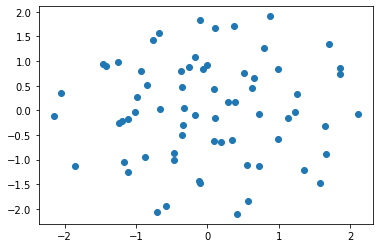

In [20]:
plt.scatter(tsne_result_scaled[:,0], tsne_result_scaled[:,1])

#3. Analyze image composition

Now we would like to analyze the image composition. To do this, we'll use the same process of image embedding again. However, we change all images into black and white images before, so that the algorithm really only concentrates on the structures in the image and the color no longer plays a role. 

Then we perform another dimension reduction, but this time we reduce to a single dimension. This way we get a scale that indicates the degree of image composition of the image.

In [21]:
import shutil

image_style_vectors = []

counter = 0
stepFolderName = "styleStep"
if not os.path.exists(stepFolderName): 
  os.mkdir(stepFolderName)

for image_path in image_paths:
  
  #Create black and white Version of the image 
  im = Image.open(image_path).convert('LA')
  
  im.save(os.path.join(stepFolderName, "sytleStep.png"), quality=95)

  #Get Vector
  vector = img2vec.get_vec(os.path.join(stepFolderName, "sytleStep.png"))
  image_style_vectors.append(vector)
  
  counter += 1

  if (counter % 10 == 0):
    print("Analyzed " + str(counter) + " of " + str(len(image_paths)) + " Images.")
    
shutil.rmtree(stepFolderName)

X2 = np.stack(list(image_style_vectors))

pca_50_2 = PCA(n_components=50)
pca_result_50_2 = pca_50_2.fit_transform(X2)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50_2.explained_variance_ratio_)))
print(np.shape(pca_result_50_2))

    
tsne2 = TSNE(n_components=1, verbose=1, n_iter=4500)
tsne_result_2 = tsne2.fit_transform(pca_result_50_2)
style_result_unscaled = StandardScaler().fit_transform(tsne_result_2)

min = 10
max = -10
for unscaled in style_result_unscaled:
  unscaledNum = unscaled[0]
  if unscaledNum < min:
    min = unscaledNum
  if unscaledNum > max:
    max = unscaledNum

image_styles = []
for unscaled in style_result_unscaled:
  styleValue = (((unscaled[0] - min) * (100 - 0)) / (max - min)) + 0
  image_styles.append("%.4f" % styleValue)

Analyzed 10 of 68 Images.
Analyzed 20 of 68 Images.
Analyzed 30 of 68 Images.
Analyzed 40 of 68 Images.
Analyzed 50 of 68 Images.
Analyzed 60 of 68 Images.
Cumulative explained variation for 50 principal components: 0.9454770088195801
(68, 50)
[t-SNE] Computing 67 nearest neighbors...
[t-SNE] Indexed 68 samples in 0.001s...
[t-SNE] Computed neighbors for 68 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 68 / 68
[t-SNE] Mean sigma: 13.236779
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.615753
[t-SNE] KL divergence after 650 iterations: 6.220466


#4. Analyze image colors 

Next, we want to analyze the colors of the images so that we can later filter or sort the images by color. For this we use the k-Means algorithm. 

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans

# Input 
colorNumber = 5

##Lets Go
imageColors = []
colorPercent = []

colorStepFolderName = "colorClusterStep"
if not os.path.exists(colorStepFolderName): 
  os.mkdir(colorStepFolderName)

loopCounter = 0
loopLength = len(image_paths)
for imagePath in image_paths:
  #Resize image
  im = Image.open(imagePath)
  im_resized = im.resize((60, 60), Image.ANTIALIAS)
  im_resized.save(os.path.join(colorStepFolderName, "colorClustStep.png"), quality=95)

  #read Image
  img=cv2.imread(os.path.join(colorStepFolderName, "colorClustStep.png"))
  #Convert Colors from BGR to RGB 
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  #Reshape Image-Array
  img=img.reshape((img.shape[1]*img.shape[0],3))
  #Find Color-Clusters with K-Means
  kmeans=KMeans(n_clusters=colorNumber)
  s=kmeans.fit(img)
  #Find Labels for Clusters
  labels=kmeans.labels_
  labels=list(labels)
  #Find Cluster Centers
  centroid=kmeans.cluster_centers_
  #Calculate Percentage of Clusters
  percent=[]
  for i in range(len(centroid)):
    j=labels.count(i)
    j=j/(len(labels))
    percent.append(j)
  imageColors.append(centroid)
  colorPercent.append(percent)

  loopCounter += 1
  if (loopCounter % 10 == 0):
    print(str(loopCounter) + " / " + str(loopLength))
shutil.rmtree(colorStepFolderName)
print("done.")

10 / 68
20 / 68
30 / 68
40 / 68
50 / 68
60 / 68
done.


The color analysis is now ready. But we still have to prepare the results a bit to write them cleanly into the CSV file later. 

In [24]:
arraycolorPercent = np.array(colorPercent)
arraycolorPercent = np.around(arraycolorPercent, 2)
stringColorPercent = []
for i in range(len(arraycolorPercent)):
  thisStr = ', '.join(map(str,arraycolorPercent[i]))
  stringColorPercent.append(thisStr)

arrayImgColors = np.array(imageColors)
arrayImgColors = np.round(arrayImgColors)
arrayImgColors = arrayImgColors.astype(int)
stringImgColors = []
for i in range(len(arrayImgColors)):
  thisStr = ""
  for e in range(len(arrayImgColors[i])):
    thisStr = thisStr + ', '.join(map(str,arrayImgColors[i][e]))
    if e < len(arrayImgColors[i]) - 1:
      thisStr = thisStr + "|"
  stringImgColors.append(thisStr)
print("Done.")

Done.


#5. Analyze abstractness 

The last thing we want to do is to find out the level of abstractness of the images. Since the project "Artificial Inspiration" deals with portraits, we use a face detection model. 

Depending on the purpose, this approach might not make sense for you. 

We use an opencv face recognition model for this purpose.

In [27]:
#download the model
!gdown --id 1-F0w6qs2RsMg1GafpgW3eImnviYHbnDx
!gdown --id 1-Dx2aHuXqu3413lWJ36JHyH9vd9zheEd
#open the model
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

#Start the analysis
abstractLevels = []
counter = 0
for imagePath in image_paths:
  thisImagePath = "/" + os.path.join("content", imagePath)
  image = cv2.imread(thisImagePath)
  image = imutils.resize(image, width=400)
  (h, w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
  net.setInput(blob)
  detections = net.forward()
  prevBoxSize = 0
  mainDetectionNum = 0
  for i in range(0, detections.shape[2]):
    prob = detections[0, 0, i, 2]
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
    boxSize = (endX - startX) * (endY - startY)
    if boxSize > prevBoxSize:
      mainDetectionNum = i
      prevBoxSize = boxSize

  abstractLevel = 1 - detections[0, 0, mainDetectionNum, 2]

  if prevBoxSize < 40000:
    abstractLevel += 0.1

  abstractLevels.append(abstractLevel)
  if (counter % 10 == 0):
    print(str(counter) + " / " + str(len(image_paths)))
  counter = counter + 1

abstractLevels = np.around(abstractLevels, 2)

#delete model again
os.remove("deploy.prototxt")
os.remove("res10_300x300_ssd_iter_140000.caffemodel")

print("done.")

Downloading...
From: https://drive.google.com/uc?id=1-F0w6qs2RsMg1GafpgW3eImnviYHbnDx
To: /content/res10_300x300_ssd_iter_140000.caffemodel
10.7MB [00:00, 106MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Dx2aHuXqu3413lWJ36JHyH9vd9zheEd
To: /content/deploy.prototxt
100% 28.1k/28.1k [00:00<00:00, 50.1MB/s]
0 / 68
10 / 68
20 / 68
30 / 68
40 / 68
50 / 68
60 / 68
done.


#6. Create CSV file

Finally, we write all the analyzed data to a CSV file. 

We can later import this file into Unity together with the created images. 

In [28]:
import csv
import pandas as pd

new = "images" #Path under which the images will be located in the Unity application

csv_name = os.path.join(baseFolder, outputName + "-img2vec.csv") #Name of the CSV file

#File path is now prepared for Unity:
old = outputName #old Path
unity_paths = []
for key in image_vectors.keys():
  new_key = key.replace(old, new)
  new_key = new_key.replace(".png", "")
  unity_paths.append(new_key) 

#Create CSV file and write image vectors into it:
with open(csv_name, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["tsneX", "tsneY", "tsneZ"])
    writer.writerows(tsne_result_scaled)

#Now open the CSV file with Pandas:
df = pd.read_csv(csv_name)

#Insert file paths of the images for Unity 
path_column = pd.DataFrame({'path': unity_paths})
df = df.merge(path_column, left_index = True, right_index = True)

#Reorder dataframe
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

#Fill CSV with color data
colors_column = pd.DataFrame({'colors': stringImgColors})
df = df.merge(colors_column, left_index = True, right_index = True)

#Fill CSV with color percentages
colors_column = pd.DataFrame({'colorPercent': stringColorPercent})
df = df.merge(colors_column, left_index = True, right_index = True)

#Fill CSV with abstract level data
colors_column = pd.DataFrame({'abstractLevel': abstractLevels})
df = df.merge(colors_column, left_index = True, right_index = True)

#Fill CSV with composition data
colors_column = pd.DataFrame({'style': image_styles})
df = df.merge(colors_column, left_index = True, right_index = True)

#Fill CSV with Drive ID of original images
colors_column = pd.DataFrame({'ID': originalImageIDs})
df = df.merge(colors_column, left_index = True, right_index = True)

#and save CSV
df.to_csv(csv_name, index = False, sep = ';')

print("All done now. Cool!")

All done now. Cool!
